In [ ]:
# Lavie Ngo
# LRP1_upstream.py - sensitivity analysis functions
# call functions with inputs to run sensitivity analysis 

# %%
from math import isclose
import numpy as np 
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Replace with Netflux files 
import LRP1_upstream as file
import LRP1_upstream_params as params

In [ ]:
#%% knockdown species at baseline and species at perturbation

[speciesNames, tau, ymax, y0, w, n, EC50] = params.loadParams()

def performSensAnalysis(w1, w2):

    # Time span
    tspan = [0, 700]

    # Run default simulation to baseline
    sol0 = solve_ivp(file.ODEfunc, tspan,  y0, args=(tau, ymax, w, n, EC50), t_eval=np.linspace(*tspan, 201))
    sol0_SS = sol0.y[:,-1]

    # Run simulation with perturbations to baseline
    # INDEXES
    idx_lrp1ag = 0
    idx_ros = 9

    w[idx_lrp1ag] = w1
    w[idx_ros] = w2

    sol1 = solve_ivp(file.ODEfunc, tspan,  sol0_SS, args=(tau, ymax, w, n, EC50), t_eval=np.linspace(*tspan, 201))
    sol1_SS = sol1.y[:,-1]

    # ODE solutions into dataframe
    sol0_df = pd.DataFrame(sol0.y.T, index = sol0.t, columns = speciesNames).melt(var_name='species', value_name = 'activity', ignore_index= False).reset_index(names='time')
    sol1_df = pd.DataFrame(sol1.y.T, index = sol1.t, columns = speciesNames).melt(var_name='species', value_name = 'activity', ignore_index= False).reset_index(names='time')
                        
    # create new column to label condition
    sol0_df['condition'] = 'base'
    sol1_df['condition'] = f'ROS, LRP1= {w1}'

    # activity levels for each species for each condition
    results = pd.concat([sol0_df, sol1_df])
    display(results) # print df

    # steady state values for each species
    results_ss = results.query('time == @tspan[1]').reset_index().drop(columns=['time', 'index'])
    display(results_ss)

    sol_kd0 = np.zeros([len(ymax), len(ymax)]) 
    sol_kd1 = np.zeros([len(ymax), len(ymax)])
    sens = np.zeros([len(ymax), len(ymax)])

    deltaP = -1 # complete knockdown

    # simulating knockdowns of each species, one by one
    for i in range(0, len(ymax)):
        print('Knockdown #', str(i+1), 'of', str(len(ymax)))
        ymax_kd = ymax.copy()
        # ymax_new = new maximum values of each species AFTER KNOCKDOWN
        # ymax_new should all be 0's since we are doing a complete knockdown
        ymax_kd[i] = (1+deltaP)*ymax[i]

        # baseline 
        sol0_kd = solve_ivp(file.ODEfunc, tspan, sol0_SS, args=(tau, ymax_kd, w, n, EC50))
        sol0_kd_SS = sol0_kd.y[:,-1]

        # with perturbation
        w[idx_lrp1ag] = w1
        w[idx_ros] = w2

        sol1_kd = solve_ivp(file.ODEfunc, tspan, sol0_kd_SS, args=(tau, ymax_kd, w, n, EC50))
        sol1_kd_SS = sol1_kd.y[:,-1]

        # change in activity for each species (KD at steady state - baseline at steady state)
        # Normalized sensitivity
        #sens[:,i] = -(sol1_kd_SS-sol0_SS)/(ymax_kd[i]-ymax[i])*ymax[i]/(sol0_SS)
        sens[:,i] = sol1_kd_SS-sol1_SS


    # if there are any non-real numbers, change them to 0 
    for i in range(0,len(ymax)):
        for j in range(0, len(ymax)):
            if np.isnan(np.real(sens[i,j]==1)):
                sens[i,j] == 0

    
    sens_df = pd.DataFrame(sens)
    sens_df = sens_df.set_index([speciesNames]).set_axis([speciesNames], axis = 1)
    sens_df.to_csv(f'/Volumes/SaucermanLab/Lavie/LRP1/Code/LRP1 Upstream Model/sens_lrp1_{w1}.csv')
    return sens_df

In [ ]:
#%% Plot Sensitivity Matrix for all species

def plotSens(sens_df):
    vcenter = 0
    vmin, vmax = -1, 1 #sens_kd.min(), sens_kd.max()
    normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
    #colormap = cm.RdBu_r
    colormap = 'seismic'

    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(20.5, 14.5)
    ax1 = sns.heatmap(sens_df, norm=normalize, cmap=colormap, xticklabels=speciesNames, yticklabels=speciesNames)

    font = {'fontname':'Arial'}
    #plt.title("Sensitivity Analysis", fontsize = 40, **font)
    plt.xlabel("Node Knockdown", fontsize = 30, **font)
    plt.ylabel("Measured Node Activity", fontsize=30, **font)

    return ax1

In [ ]:
#%% calculate overall network influence/sensitivity

#Overall network influence analysis 

#Sum columns to calculate total influence of knockdown
# Sum rows to calculate total sensitivity
# Make submatrix with the most sensitive outputs and most influential node knockdowns
def sensNetworkInfluence(sens_file):

    file = pd.read_csv(sens_file)
    sens_df = file.set_index(['Unnamed: 0']).rename_axis('Species')

    sums = {'rows':[], 'cols':[], 'norm_rows':[], 'norm_cols':[], 'top10_rows':[], 'top10_cols':[]}

    for name, row in sens_df.iterrows():
        sum_row = np.sum(row)
        sum_row_abs = np.abs(sum_row)
        sums['rows'].append(sum_row_abs)


    for name, col in sens_df.items():
        sum_col = np.sum(col)
        sum_col_abs = np.abs(sum_col)
        sums['cols'].append(sum_col_abs)

    # sum of all rows and cols
    sum_all_rows = np.sum(sums['rows'])   
    sum_all_cols = np.sum(sums['cols'])

    # normalize sum of each node by dividing by total sum
    sums['norm_rows'] = sums['rows']/sum_all_rows
    sums['norm_cols'] = sums['cols']/sum_all_cols

    # rank top 10 rows (most sensitive)
    sum_norm_rows_df = pd.DataFrame(sums['norm_rows']).set_index([speciesNames]).sort_values(by=0, ascending=False)
    # rank top 10 cols (most influential knockdowns)
    sum_norm_cols_df = pd.DataFrame(sums['norm_cols']).set_index([speciesNames]).sort_values(by=0, ascending=False)
        
    sums['top10_rows']= pd.DataFrame(sum_norm_rows_df[0][0:10]).reset_index(names='Species')
    sums['top10_cols'] = pd.DataFrame(sum_norm_cols_df[0][0:10]).reset_index(names='Species')

    return sums

In [ ]:
#%% Plot ranked sensitivity matrix

def plotRankedSens(sens_file, top10_rows, top10_cols):

    file = pd.read_csv(sens_file)
    sens_df = file.set_index(['Unnamed: 0']).rename_axis('Species')

    # subset matrix
    subset_cols = sens_df[top10_cols['Species']].set_index([speciesNames])
    top10_matrix = subset_cols.loc[top10_rows['Species']]

    vcenter = 0
    vmin, vmax = -1, 1 #sens_kd.min(), sens_kd.max()
    normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
    #colormap = cm.RdBu_r
    colormap = 'seismic'

    fig1, ax1 = plt.subplots()
    ax1 = sns.heatmap(top10_matrix, norm=normalize, cmap=colormap)
    ax1.tick_params(axis='x', rotation=0, labelsize = 8)

    font = {'fontname':'Arial'}
    #plt.title("Sensitivity Analysis", fontsize = 40, **font)
    plt.xlabel("Node Knockdown", fontsize = 10, **font)
    plt.ylabel("Measured Node Activity", fontsize=10, **font)

    return ax1

In [ ]:
#%% call sensitivity matrix functions

# inputs: w1 is lrp1ag weight, w2 is ROS weight
sens_lrp1ag_1 = performSensAnalysis(1, 0.4)
sens_plot = plotSens(sens_lrp1ag_1)

/Volumes/SaucermanLab/Lavie/LRP1/LRP1 Project Code/LRP1-Project/LRP1 Upstream Model/LRP1 Model Sensitivity Analysis/LRP1_upstream.py:150: RuntimeWarning: invalid value encountered in scalar power
  fact = w*(beta*x**n)/(K**n+x**n)


,time,species,activity,condition
0,0.0,Akt,0.000000,base
1,3.5,Akt,0.305898,base
2,7.0,Akt,0.906269,base
3,10.5,Akt,0.993470,base
4,14.0,Akt,0.999637,base
...,...,...,...,...
13663,686.0,xIAPt,1.000000,"ROS, LRP1= 1"
13664,689.5,xIAPt,1.000000,"ROS, LRP1= 1"
13665,693.0,xIAPt,1.000000,"ROS, LRP1= 1"
13666,696.5,xIAPt,1.000000,"ROS, LRP1= 1"


,species,activity,condition
0,Akt,1.000000e+00,base
1,AP1,2.159135e-04,base
2,apoptosis,7.253541e-300,base
3,ASK1,2.109561e-02,base
4,Bad,2.159135e-04,base
...,...,...,...
131,Trxt,1.000000e+00,"ROS, LRP1= 1"
132,VEGF,1.750000e-01,"ROS, LRP1= 1"
133,VEGFR,1.353009e-01,"ROS, LRP1= 1"
134,xIAP,8.529409e-01,"ROS, LRP1= 1"


Knockdown # 1 of 68


/Volumes/SaucermanLab/Lavie/LRP1/LRP1 Project Code/LRP1-Project/LRP1 Upstream Model/LRP1 Model Sensitivity Analysis/LRP1_upstream.py:150: RuntimeWarning: invalid value encountered in scalar power
  fact = w*(beta*x**n)/(K**n+x**n)


Knockdown # 2 of 68
Knockdown # 3 of 68
Knockdown # 4 of 68
Knockdown # 5 of 68
Knockdown # 6 of 68
Knockdown # 7 of 68
Knockdown # 8 of 68
Knockdown # 9 of 68
Knockdown # 10 of 68
Knockdown # 11 of 68
Knockdown # 12 of 68
Knockdown # 13 of 68
Knockdown # 14 of 68
Knockdown # 15 of 68
Knockdown # 16 of 68
Knockdown # 17 of 68
Knockdown # 18 of 68
Knockdown # 19 of 68
Knockdown # 20 of 68
Knockdown # 21 of 68
Knockdown # 22 of 68
Knockdown # 23 of 68
Knockdown # 24 of 68
Knockdown # 25 of 68
Knockdown # 26 of 68
Knockdown # 27 of 68
Knockdown # 28 of 68
Knockdown # 29 of 68
Knockdown # 30 of 68
Knockdown # 31 of 68
Knockdown # 32 of 68
Knockdown # 33 of 68
Knockdown # 34 of 68
Knockdown # 35 of 68
Knockdown # 36 of 68
Knockdown # 37 of 68
Knockdown # 38 of 68
Knockdown # 39 of 68
Knockdown # 40 of 68
Knockdown # 41 of 68
Knockdown # 42 of 68
Knockdown # 43 of 68
Knockdown # 44 of 68
Knockdown # 45 of 68
Knockdown # 46 of 68
Knockdown # 47 of 68
Knockdown # 48 of 68
Knockdown # 49 of 68


OSError: Cannot save file into a non-existent directory: '/Volumes/SaucermanLab/Lavie/LRP1/Code/LRP1 Upstream Model'

In [ ]:
#%% call sensitivity matrix influence analysis 

sens_file = '/Volumes/SaucermanLab/Lavie/LRP1/Code/LRP1 Upstream Model/sens_lrp1_0.csv'
sums_lrp1 = sensNetworkInfluence(sens_file)
ranked_plot = plotRankedSens(sens_file, sums_lrp1['top10_rows'], sums_lrp1['top10_cols'])

: 

In [ ]:
#%% Plot ranked sensitivity matrix

def plotRankedSens(sens_file, top10_rows, top10_cols):

    file = pd.read_csv(sens_file)
    sens_df = file.set_index(['Unnamed: 0']).rename_axis('Species')

    # subset matrix
    subset_cols = sens_df[top10_cols['Species']].set_index([speciesNames])
    top10_matrix = subset_cols.loc[top10_rows['Species']]

    vcenter = 0
    vmin, vmax = -1, 1 #sens_kd.min(), sens_kd.max()
    normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
    #colormap = cm.RdBu_r
    colormap = 'seismic'

    fig1, ax1 = plt.subplots()
    ax1 = sns.heatmap(top10_matrix, norm=normalize, cmap=colormap)
    ax1.tick_params(axis='x', rotation=0, labelsize = 8)

    font = {'fontname':'Arial'}
    #plt.title("Sensitivity Analysis", fontsize = 40, **font)
    plt.xlabel("Node Knockdown", fontsize = 10, **font)
    plt.ylabel("Measured Node Activity", fontsize=10, **font)

    return ax1

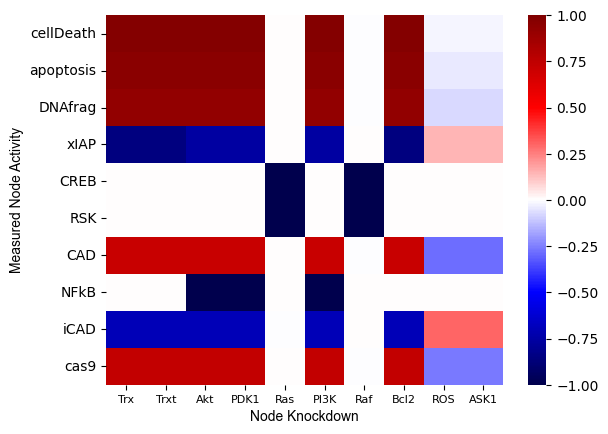

In [ ]:
#%% call sensitivity matrix influence analysis 

sens_file = '/Volumes/SaucermanLab/Lavie/LRP1/LRP1 Project Code/LRP1-Project/LRP1 Upstream Model/LRP1 Model Sensitivity Analysis/sens_lrp1_1.csv'
sums_lrp1 = sensNetworkInfluence(sens_file)
ranked_plot = plotRankedSens(sens_file, sums_lrp1['top10_rows'], sums_lrp1['top10_cols'])